<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-is-the-Sentinel-2-Satellite?" data-toc-modified-id="What-is-the-Sentinel-2-Satellite?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What is the Sentinel-2 Satellite?</a></span></li><li><span><a href="#What-does-this-dataset-contain?" data-toc-modified-id="What-does-this-dataset-contain?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>What does this dataset contain?</a></span></li></ul></div>

Наш проект основан на работе Diego Suarez - https://www.kaggle.com/code/diegoasuarezg/satellite-land-classification-tpu-convnet
bronze medal 🛰🌎 Satellite land Classification TPU + ConvNet

Нам удалось повысить качество классификации изменив функцию для подбора learning rate.

Цель проекта :
- Построение модели классификации изображений поверхности планеты и алгоритмов выявления существенных изменений в природе.
- Отслеживание изменений в природном ланшафте.
- Выявление несанкционнированных Техногенных изменений в охраняемых зонах.


# Summary

In this notebook I use the EuroSAT image dataset to classify land uses from images taken by the Sentinel-2 satellite. To do this, I built a ConvNet with Efficient as backbone and then proceeded to evaluate its accuracy. 

Since the image dataset is in TFRecords format, I create a data pipeline in order to successfully feed it to kaggles TPU accelerator.

## What is the Sentinel-2 Satellite?

The Copernicus Sentinel-2 mission comprises a constellation of two polar-orbiting satellites that are placed in the same sun-synchronous orbit, phased at 180° to each other. Its **primary objective is to monitor variability in land surface conditions**.

<div style="width:100%;text-align: center;"> <img align=middle src=https://eijournal.com/wp-content/uploads/2015/03/sentinel2a_bands.jpg" width="500" height="500" class ="center"/></div>

## What does this dataset contain?

This dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of **10 classes with in total 27,000 labeled and geo-referenced image.**

Original Dataset and general information

* [EuroSAT : Land Use and Land Cover Classification with Sentinel-2](https://github.com/phelber/eurosat)

* [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

* [How to Use Kaggle Tensor Processing Units (TPUs)](https://www.kaggle.com/docs/tpu)


Data Card

* [EuroSAT Dataset](https://www.kaggle.com/datasets/ryanholbrook/eurosat)

Notebook references 

* [SETI-BL: TF Starter TPU ](https://www.kaggle.com/code/awsaf49/seti-bl-spatial-info-tf-tpu) By AWSAF

* [Create Your First Submission](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission) by R.Holbrook, A.Cook and P.Culliton

# Libraries import

Let's start by importing efficientnet.

In [1]:
# pip installing efficientnet 
!pip install efficientnet
!pip install -U scikit-learn scipy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 82.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.


In [2]:
!pip install plotly 

In [3]:
!pip install seaborn

Let's define the libraries that we will be using throughout this notebook.

In [4]:
# General purpose 
import os
from glob import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable all logging output from TensorFlow
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'

# Reproducibility
import random

# Data manipulation
import numpy as np
import pandas as pd

# Read JSON files 
import json

# Machine learning models and utilities
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import efficientnet.tfkeras as efn
import tensorflow.keras.backend as K

# Model evaluation

import sklearn
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             confusion_matrix
                            )

# Data visualization
import matplotlib.pyplot as plt
from plotly.offline import (init_notebook_mode,
                            iplot,
                            plot
                           )
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
from skimage.metrics import structural_similarity as compare_ssim
import cv2
import numpy as np


# Notebook configuration 

Before importing the dataset, let's define some of the parameters that we will be using in this notebook.

In [5]:
# Use TPU accelerator
DEVICE = "TPU" #or "GPU"

# Batch size 
BATCH_SIZE = 16 * 8 #Batch size 16 * 8 Replicas

# Seed value for reproducibility
SEED = 29

# Images size
IMG_SIZES = [[64, 64]]
IMAG_SIZES = [64, 64]

# Total number of epochs
EPOCHS = [12]

# Augment and transform images 
AUGMENT   = True
TRANSFORM = True

# Transormations parameters
ROT_    = 0.0
SHR_    = 2.0
HZOOM_  = 8.0
WZOOM_  = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0
sat  = (0.7, 1.3) #Saturation Range 
cont = (0.8, 1.2) #Contrast Range
bri  =  0.1

Lastly, let's create a function that will guarantee notebook reproducibility.

In [6]:
# Seeding all the notebook for reproducibility purposes

def seed_it(SEED):
    
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)

    print('Notebook has been seeded successfully')

In [7]:
seed_it(SEED)

Notebook has been seeded successfully


# Dataset description and exploratory analysis 

We will start by reading the information in the JSON and TXT files.

In [8]:
# Reading JSON and TXT files

info_img=json.load(open('/kaggle/input/eurosat/eurosat/rgb/2.0.0/image.image.json'))
info_dataset=json.load(open('/kaggle/input/eurosat/eurosat/rgb/2.0.0/dataset_info.json'))
info_label=list(open("/kaggle/input/eurosat/eurosat/rgb/2.0.0/label.labels.txt",'r'))

Let's read the contents of the dataset_info.json file to analyze its data.

In [9]:
# Dataset info
for i in info_dataset:
    print(json.dumps(info_dataset[i]),'\n')

"@misc{helber2017eurosat,\n    title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},\n    author={Patrick Helber and Benjamin Bischke and Andreas Dengel and Damian Borth},\n    year={2017},\n    eprint={1709.00029},\n    archivePrefix={arXiv},\n    primaryClass={cs.CV}\n}" 

"EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral\nbands and consisting of 10 classes with 27000 labeled and\ngeo-referenced samples.\n\nTwo datasets are offered:\n- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.\n- all: Contains all 13 bands in the original value range (float32).\n\nURL: https://github.com/phelber/eurosat" 

"94280567" 

{"urls": ["https://github.com/phelber/eurosat"]} 

"eurosat" 

{"feature": [{"name": "filename", "type": "BYTES"}, {"name": "image", "shape": {"dim": [{"size": "64"}, {"size": "64"}, {"size": "3"}]}, "type": "INT"}, {"name": "label", "type": "INT"}]} 

"94280567" 

[{"name

It seems that the dataset_info.json file contains general information (metadata) about the dataset, such as the number of images it contains and the data type of each feature.

Now let's read the file image.json file.

In [10]:
# Image info
print(json.dumps(info_img))

{"encoding_format": "png", "shape": [64, 64, 3]}


It seems that the original images were encoded in .png format with a size of 64x64 pixels and 3 color channels. However, I suspect that the images contained in the TFRecord data file are encoded as JPG, so I will decode them as such.

We now explore what the label.txt file. 

In [11]:
# Label info
for i in enumerate (info_label):
    print(i[0],i[1]) 

0 AnnualCrop

1 Forest

2 HerbaceousVegetation

3 Highway

4 Industrial

5 Pasture

6 PermanentCrop

7 Residential

8 River

9 SeaLake



We see that the image dataset contains in total 10 classes.

Now that we have an overall understanding of what we are dealing with, let's just take a sneak peek of the TFRecord file.

In [12]:
#Data (TFRecord) snip inspection 

raw_dataset = tf.data.TFRecordDataset("/kaggle/input/eurosat/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "SeaLake_2401.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\

So what do the images in the TFRecord look like? Well, in the next image we see a sample overview of the images.

<div style="width:100%;text-align: center;"> <img align=middle src="https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg" width="700" height="700" class ="center"/></div>

Now we need to find out how the classes are distributed. We will create a Pandas Dataframe and find out.

In [13]:
# Parse TFRecords 
def parse_df_element(element):
    parser = {
        'filename': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    # create an example:
    content = tf.io.parse_single_example(element, parser)
    return content['filename'], content['image'], content['label']

# Map dataset
parsed_tf_records = raw_dataset.map(parse_df_element)

# Create dataframe
df = pd.DataFrame(
    parsed_tf_records.as_numpy_iterator(),
    columns=['filename', 'image', 'label']
)


In [14]:
#Check head and tail of the dataset
df.head(3).append(df.tail(3))

filename  \
0            b'SeaLake_2401.jpg'   
1      b'PermanentCrop_1790.jpg'   
2             b'SeaLake_649.jpg'   
26997           b'Forest_87.jpg'   
26998     b'Residential_541.jpg'   
26999          b'River_2223.jpg'   

                                                   image  label  
0      b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      9  
1      b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      6  
2      b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      9  
26997  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      1  
26998  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      7  
26999  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      8

OK, now that we have got the dataframe, let's proceed to plotting the result to have a better visualization of the class balance.  

In [15]:
types = (str(info_label).replace('\\n','')
                .replace('[','')
                .replace(']','')
                .replace("'",'')
                .replace(",",'')
                .split())
classes_counts = df.label.value_counts().reset_index().sort_values(by='index')
classes_counts['class_name'] = types
classes_counts

index  label            class_name
3      0   3000            AnnualCrop
2      1   3000                Forest
4      2   3000  HerbaceousVegetation
8      3   2500               Highway
6      4   2500            Industrial
9      5   2000               Pasture
5      6   2500         PermanentCrop
1      7   3000           Residential
7      8   2500                 River
0      9   3000               SeaLake

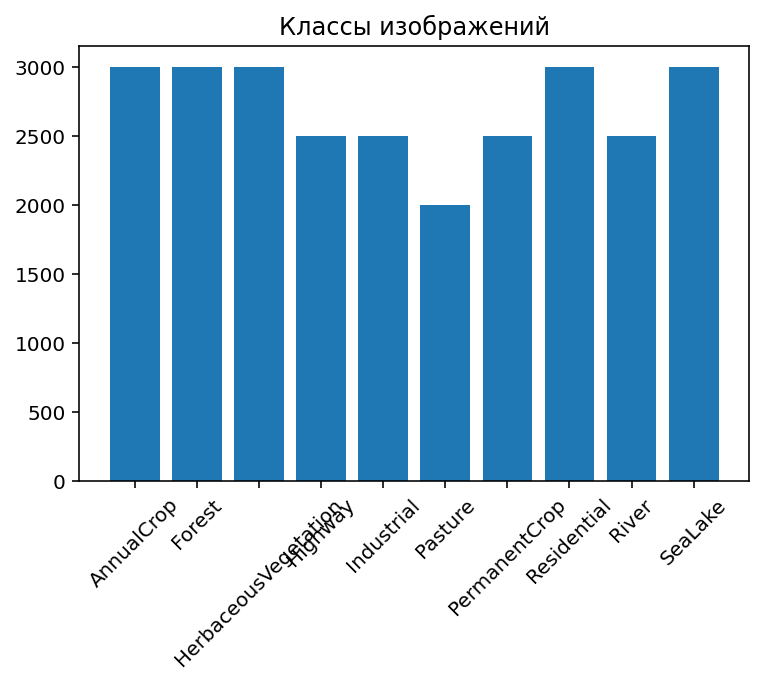

In [16]:
plt.bar(classes_counts.class_name, classes_counts.label)
plt.title('Классы изображений')
plt.xticks(rotation=45)
plt.show();

From the bar graph we can deduct that the classes are quite balanced. This is a good sign. 

Now that we have gathered all the information and inspected it, we  proceed to establish a connection with Kaggle's TPU to accelerate the model training. 

# TPU Connection

TPU's are hardware accelerators specialized in deep learning tasks. They are equipped with 128GB of high-speed memory allowing larger batches, larger models and also larger training inputs.

For more information about the kaggle's TPU please refer to the document in the following link:

[Tensor Processing Units (TPUs)](https://www.kaggle.com/docs/tpu)

<div style="width:100%;text-align: center;"> <img align=middle src="https://storage.googleapis.com/kaggle-media/tpu/tpuv3angle.jpg" width="400" height="400" class ="center"/></div>

Following codes automatically detects hardware(tpu or gpu or cpu):

In [17]:
# Connect to TPU V3-8 accelator 
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            # instantiate a distribution strategy
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

# If Can't detect TPU accelerator connect to GPU else use CPU    
if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    # instantiate a distribution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# Image augmentation

To make our model more robust, we perform some slight alterations to the images. 

In the subsequent code cell, we first define a function to obtain various transformation matrices. The second function applies the transformation matrix with random parameters to one of the training images.

In [18]:
# Augment image: rotation, shear, zoom and shift 

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=IMG_SIZES[0]):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
        
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])
        
    NEW_DIM = DIM[0]
    
    XDIM = NEW_DIM%2
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(NEW_DIM//2, -NEW_DIM//2,-1), NEW_DIM)
    y   = tf.tile(tf.range(-NEW_DIM//2, NEW_DIM//2), [NEW_DIM])
    z   = tf.ones([NEW_DIM*NEW_DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -NEW_DIM//2+XDIM+1, NEW_DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([NEW_DIM//2-idx2[0,], NEW_DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
    
    if DIM[0]!=DIM[1]:
        image = tf.reshape(d,[NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])
        
    return image

# Data Pipeline

Since we are working with data stored in the tfrecords format, it is necessary to build a data pipeline to convert the data into a format that can be used by the ConvNet model.

Let's start by obtaining the Google Storage dataset path.

In [19]:
# Get Google Cloud Storage - Dastaset path

GCS_DS_PATH = KaggleDatasets().get_gcs_path('eurosat')
print(GCS_DS_PATH)

gs://kds-ce593078e9ab618ab6e6e1b08409a78c425a3b34923b90f0ece6a26f


Now, we define a function to read and decode the images in the dataset. Next, we read the dataset labels and finally load the dataset.

In [20]:
# Load TFRecord format dataset

GCS_PATH = GCS_DS_PATH + '/eurosat/rgb/2.0.0/eurosat-train'
AUTO = tf.data.experimental.AUTOTUNE

FILENAMES = tf.io.gfile.glob(GCS_PATH +'.tfrecord-00000-of-00001')

CLASSES = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
           'Pasture', 'PermanentCrop','Residential',
           'River','SeaLake']  

# Decode jpeg images 
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAG_SIZES, 3]) # explicit size needed for TPU
    return image

# Read labels
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'filename': tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

# Load dataset
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding m,data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

We then build a function that applies augmentations to the training set. Additionally, we build functions that allow us to obtain the training and validation datasets.

In [21]:
# Images random augmentations 
def data_augment(img, label, dim=IMG_SIZES[0]):
    img = transform(img,DIM=dim) if TRANSFORM else img
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, sat[0], sat[1])
    img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)     
    
    return img, label   

# Get training dataset
def get_training_dataset():
    dataset = train_dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(1024*2, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# Get validation dataset 
def get_validation_dataset(ordered=False):
    dataset = val_dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Count number of items in the dataset 
def count_data_items(filenames):
    return sum(1 for i in tf.data.TFRecordDataset(filenames))

Let's count the total number of files inside the TFRecord format.

In [22]:
# Count total number of images in the dataset 
NUM_IMAGES = count_data_items(FILENAMES)

print('Dataset: {} total images'.format(NUM_IMAGES))

Dataset: 27000 total images


Since we don't have a separate test or validation dataset, we split the training set to obtain a validation set that can be used to evaluate our model later.

In [23]:
# Train - Validation split 
train_size = int(0.8 * NUM_IMAGES)
val_size = int(0.20 * NUM_IMAGES)

full_dataset=load_dataset(FILENAMES, labeled=True)
full_dataset = full_dataset.shuffle(1024*2, seed=SEED)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

Finally, we are ready to obtain our training and validation sets.

In [24]:
# Get training dataset 
ds_train = get_training_dataset()

# Get validation dataset
ds_val=get_validation_dataset()

In [25]:
# Training and Validation set details 
print("Training:", ds_train,'\n')
print("Validation:", ds_val,'\n')

Training: <PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)> 

Validation: <PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)> 



In [26]:
# Training batch examples

np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 64, 64, 3) (128,)
(128, 64, 64, 3) (128,)
(128, 64, 64, 3) (128,)
Training data label examples: [1 3 5 ... 9 0 4]


Each batch contains 128 images with 64x64x3(rgb) dimensions.

Let's now define our plotting functions.



In [27]:
#Plotting functions 

# Transform images and labels batch to numpy array 
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

# Label title / will compare if label is correct or not 
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

# Display one image 
def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

# Display batch of images 
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

# Display training curves  
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
def display_confusion_matrix(cmat):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 10})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""

In [28]:
# Get a 20 image form one of the training batch 
ds_iter = iter(ds_train.unbatch().batch(20))

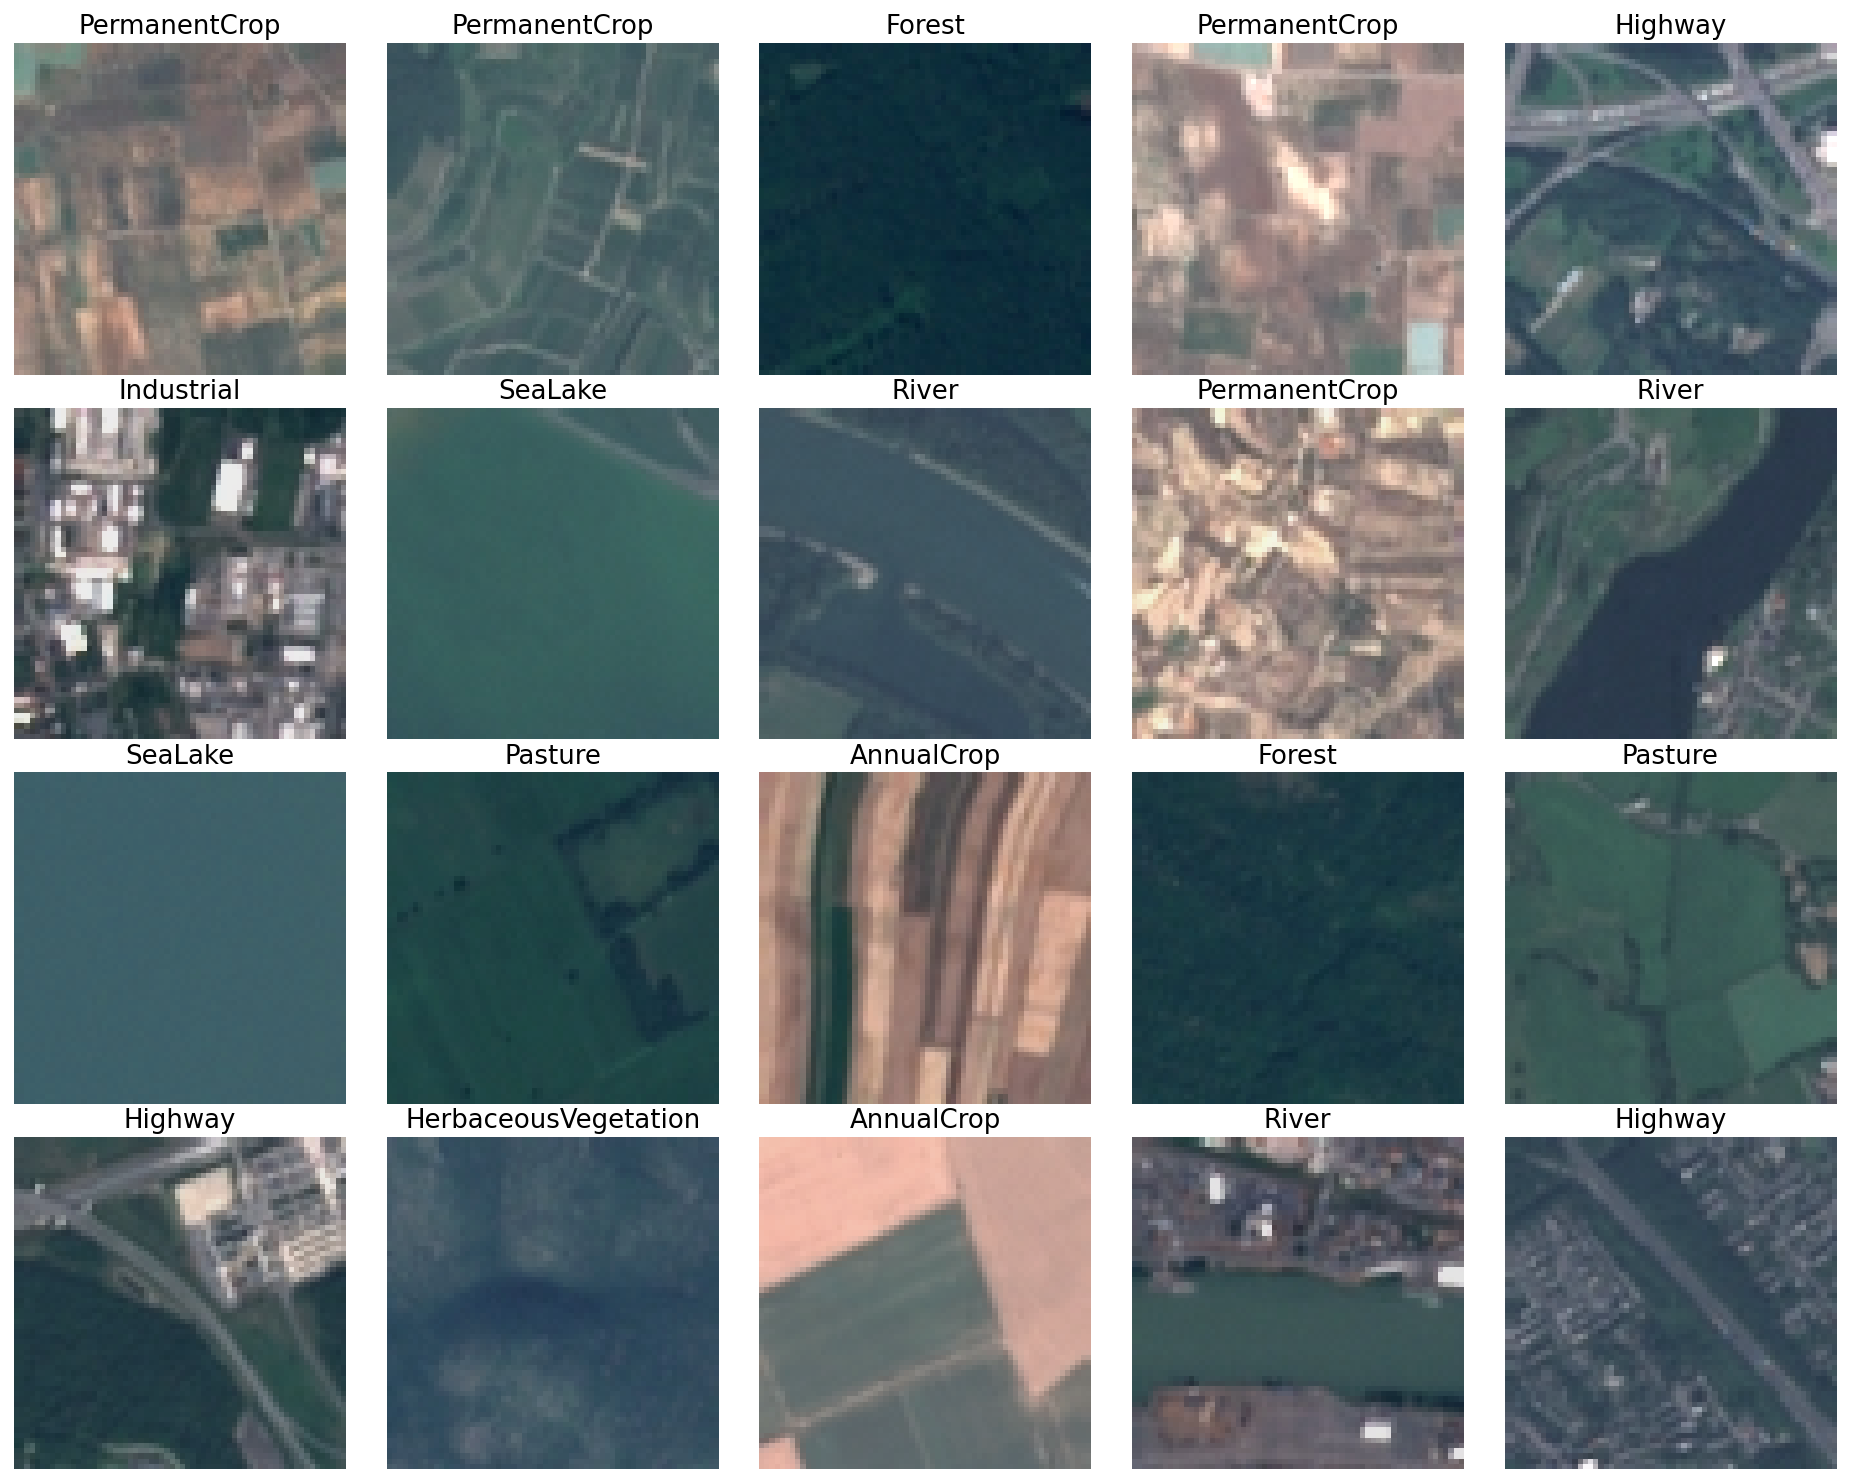

In [29]:
# Display sample images 
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

Okay, now that we have our data ready to be fed to the model, it's time to build the model.

# ConvNet building

The reason for using EfficientNet as a backbone base is that it can lead to improved performance and efficiency compared to other popular architectures when used in a ConvNet. In real-world scenarios, processing a large number of images in a fast and efficient manner is crucial, and EfficientNet is well-suited for such tasks.

The following image depicts the architecture behind EfficientNet.

<div style="width:100%;text-align: center;"> <img align=middle src="https://1.bp.blogspot.com/-MQO5qKuTT8c/XpdE8_IwpsI/AAAAAAAAFtg/mSjhF2ws5FYxwcHN6h9_l5DqYzQlNYJwwCLcBGAsYHQ/s1600/image1.png" width="700" height="700" class ="center"/></div>

In [30]:
# Use EfficientNet B7 as backbone base classification model 
with strategy.scope():
    pretrained_model = efn.EfficientNetB7(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAG_SIZES, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),# use GAP to get pooling result form conv outputs
        tf.keras.layers.Dense(32, activation= 'relu'), # Dense layer with relu activation function for non-linearity
        tf.keras.layers.Dense(len(CLASSES), activation='softmax') # Output layer with 10 neurons and softmax axtivation function
    ])

258449408/258434480 [==============================] - 8s 0us/step


In [31]:
# Model optimizer, loss and metric
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2, 2, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                81952     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 64,179,962
Trainable params: 82,282
Non-trainable params: 64,097,680
_________________________________________________________________


We now define a learning rate schedule. So, why use it? well consider the following:

A learning rate schedule helps the model to learn more efficiently by starting with larger updates to the model parameters and gradually reducing the step size as training progresses. This can lead to better model performance and more accurate predictions.

Learning rate schedule: 1e-05 to 0.001 to 0.00027


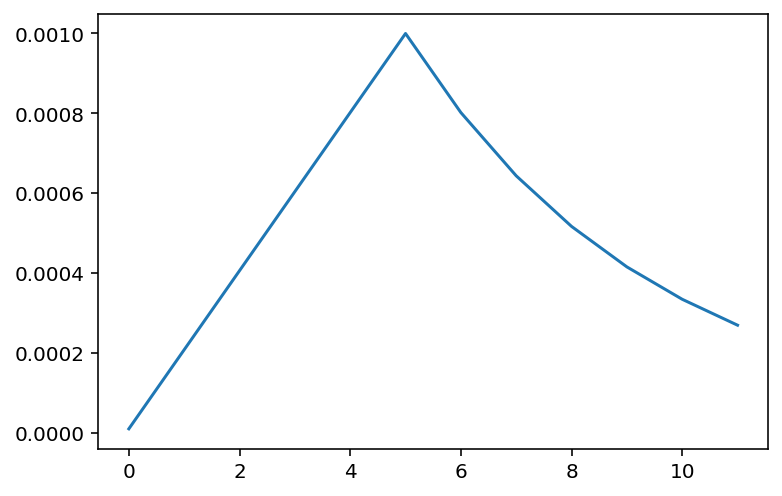

In [32]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.001,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS[0])]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

We are ready to fit our model!

In [33]:
# Training epochs definition 
STEPS_PER_EPOCH = train_size // BATCH_SIZE

# Model fitting 
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS[0],
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

Epoch 1/12

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
168/168 [==============================] - 80s 312ms/step - loss: 2.1902 - sparse_categorical_accuracy: 0.2032 - val_loss: 2.0531 - val_sparse_categorical_accuracy: 0.2896
Epoch 2/12

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000379979611.
168/168 [==============================] - 36s 215ms/step - loss: 1.8826 - sparse_categorical_accuracy: 0.3584 - val_loss: 1.7559 - val_sparse_categorical_accuracy: 0.4396
Epoch 3/12

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000284984707.
168/168 [==============================] - 31s 187ms/step - loss: 1.6963 - sparse_categorical_accuracy: 0.4261 - val_loss: 1.6109 - val_sparse_categorical_accuracy: 0.4509
Epoch 4/12

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000189989806.
168/168 [==============================] - 29s 175ms/step - loss: 1.5814 - sparse_categorical_accuracy: 

# ConvNet evaluation 

Now, we will evaluate the performance of our model by plotting a loss versus validation loss curve and an accuracy versus validation curve.

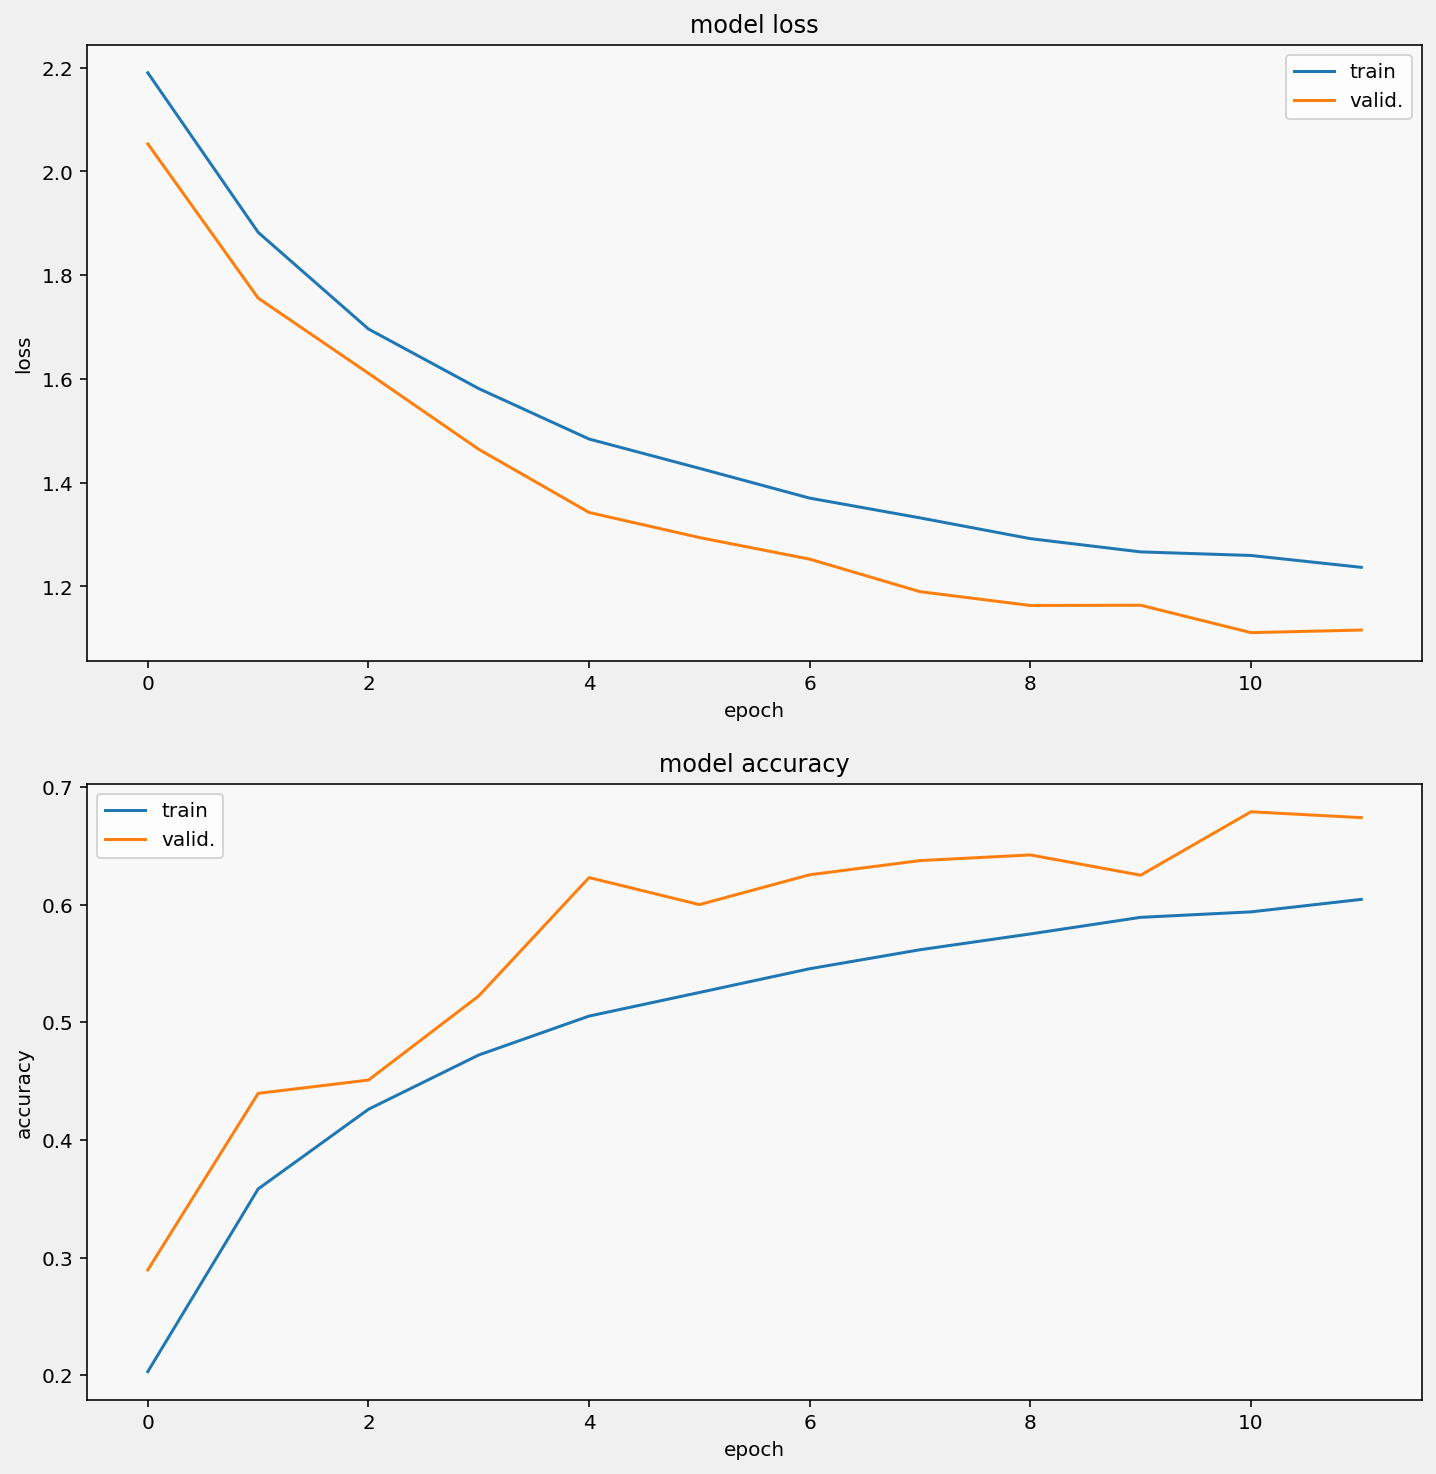

In [34]:
#  Loss vs Validation Loss curve
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)

# Accuracy vs Validation accuracy curve
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

Not bad, 56% accuaracy for a 10 class output model.

Let's see which classes the model had more trouble classifying by plotting a confusion matrix.

<b> Поиграв с гиперпараметрами получилось увеличить качество модели автора до 0.69 </b>

In [35]:
# Calculate confusion matrix 

cmdataset = get_validation_dataset()
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(val_size))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    y_true=cm_correct_labels,
    y_pred=cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

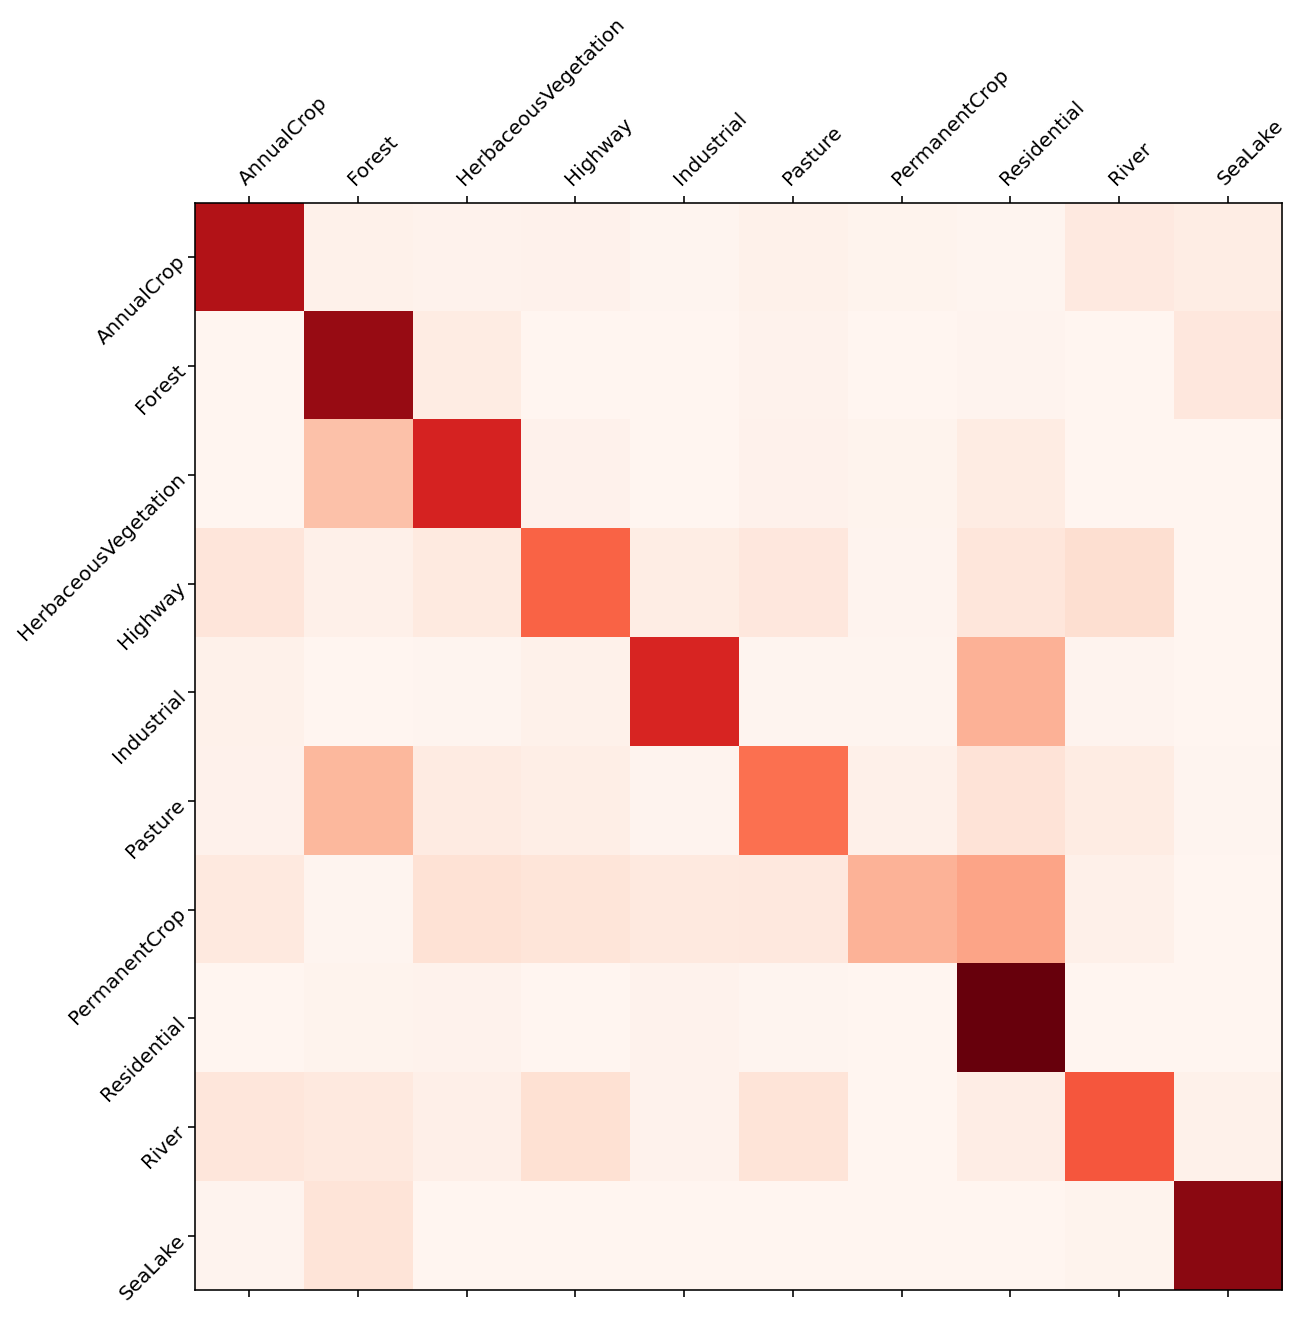

In [36]:
display_confusion_matrix(cmat)

The model seems to be confusing PASTURES with FOREST (Makes sense),RESIDENTIAL get confused a lot with INDUSTRIAL (Also makes sense) and PERMANENTCROP with RESIDENTIAL.

Now, let's evaluate the overall performance of the model by examining its F1 score, precision, and recall.

In [37]:
#  F1, precision and recall score

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

print('F1 score of the model is:',round(score,3),'\n')
print('Precision of the model is:',round(precision,3),'\n')
print('Recall of the model is:',round(recall,3),'\n')

F1 score of the model is: 0.647 

Precision of the model is: 0.686 

Recall of the model is: 0.653 



Finally let's see a visual validation matrix.

In [38]:
# Get 20 images from the validation batch

dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

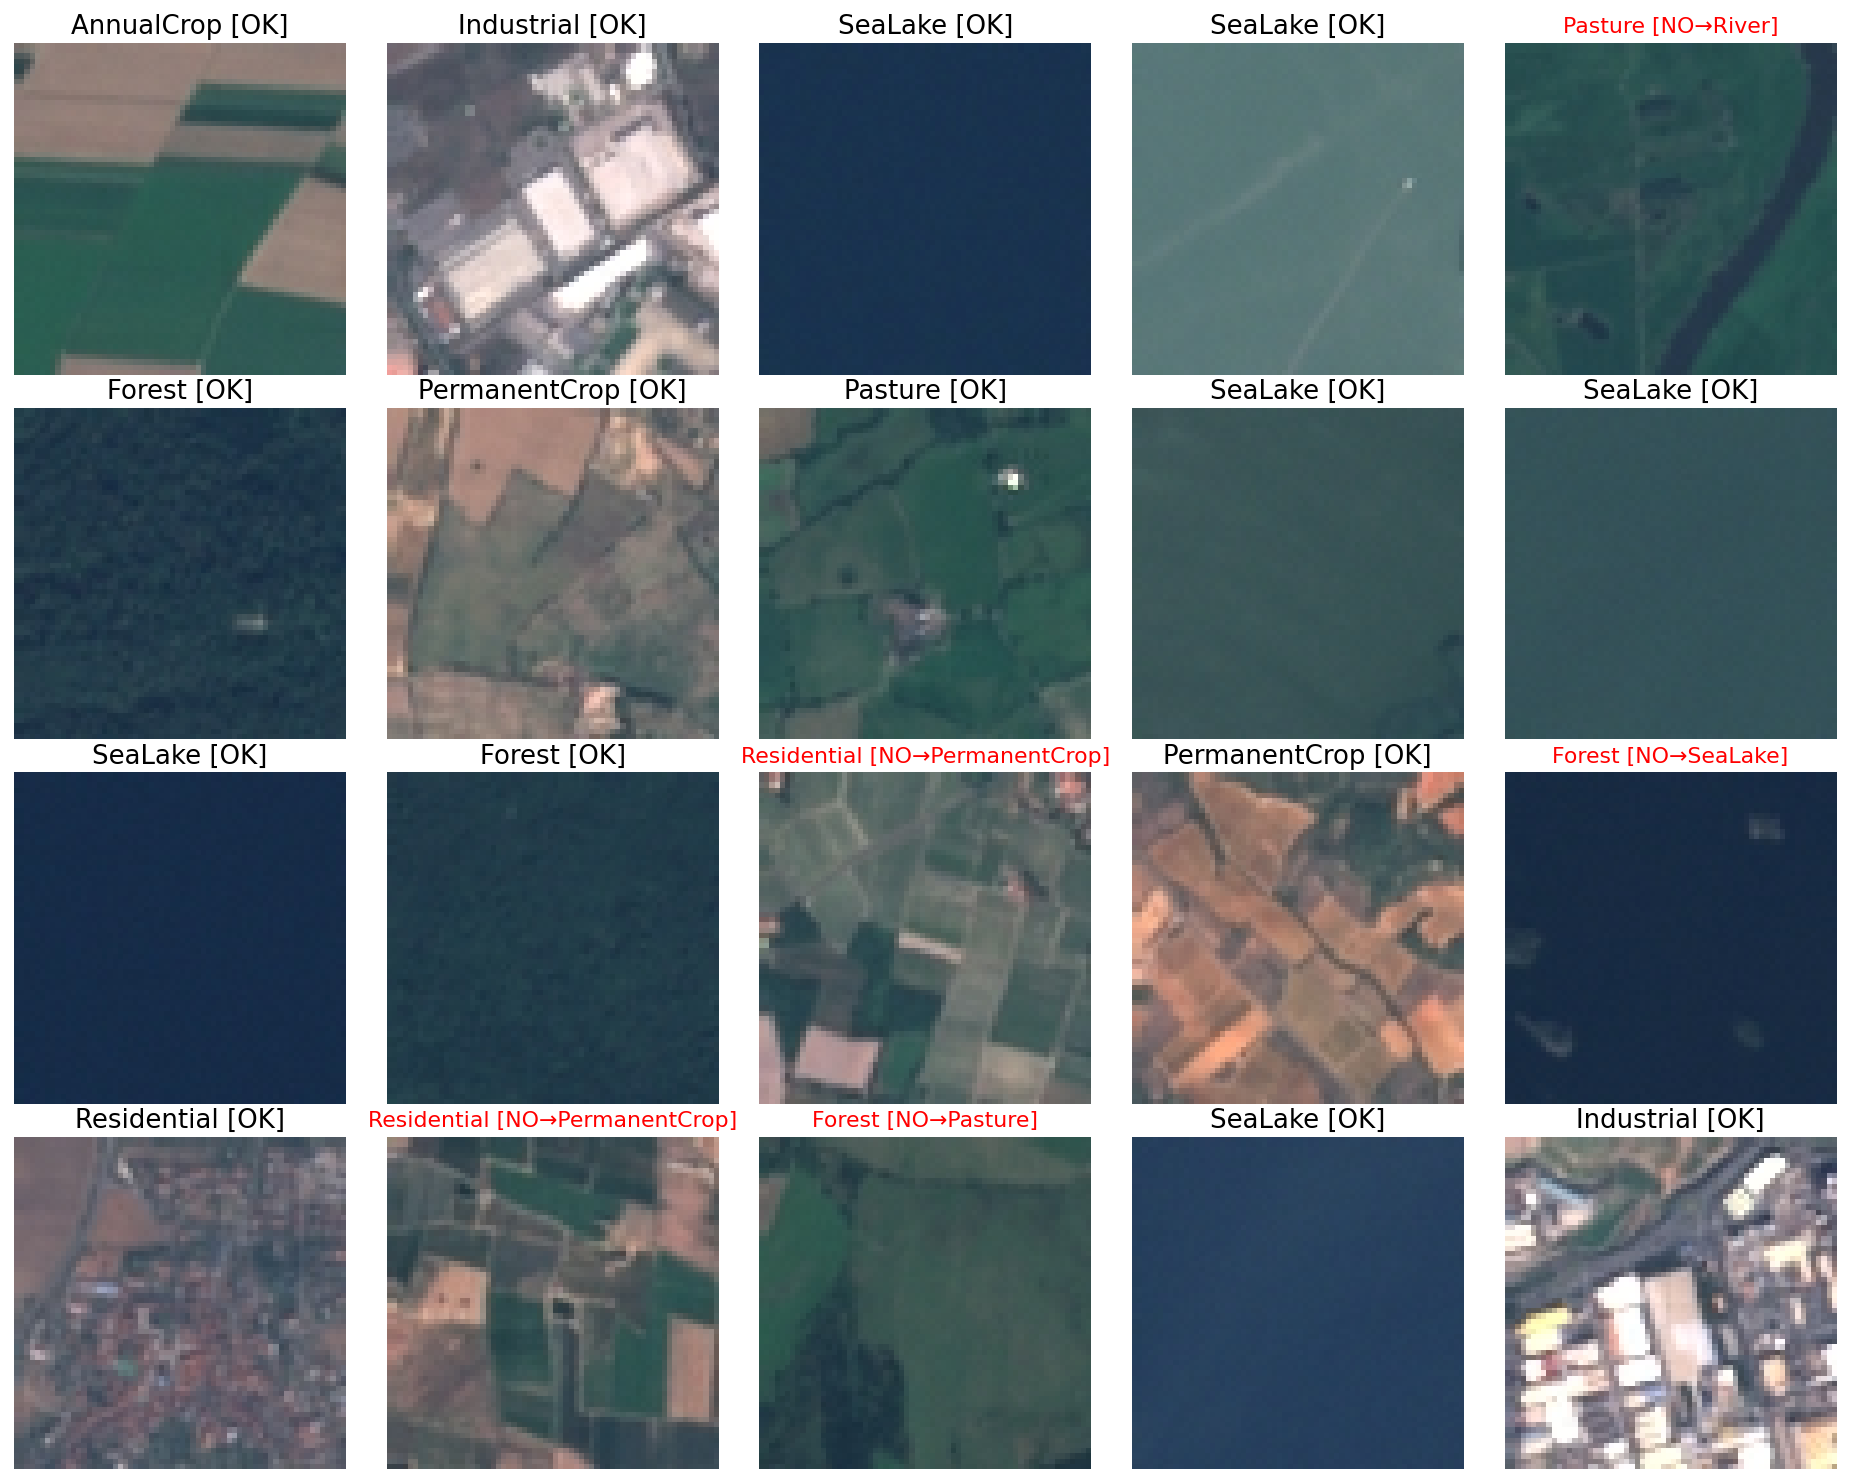

In [39]:
# Perform visual validation

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [1]:
! pip install opencv-python

In [4]:
# Загрузка изображений
img1 = cv2.imread('left1.jpg')
img2 = cv2.imread('right1.jpg')

# Преобразование изображений в оттенки серого
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Вычисление индекса структурного сходства (SSIM)
similarity_score, diff_map = compare_ssim(img1_gray, img2_gray, full=True)
print("Похожесть изображений: {:.4f}%".format(similarity_score * 100))
if similarity_score > 0.99:
    print('Изменения в пределах 5%, не требуют внимания')
else:
    print('Целесообразно обратить внимание на область исследований - Произошли существенные изменения.')



Похожесть изображений: 96.8570%
Целесообразно обратить внимание на область исследований - Произошли существенные изменения.


In [34]:
# load images
image1 = cv2.imread("left1.jpg")
image2 = cv2.imread("right1.jpg")

# compute difference
difference = cv2.subtract(image1, image2)
# color the mask red
Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [255, 0, 0]

# add the red mask to the images to make the differences obvious
image1[mask != 255] = [0, 0, 255]
image2[mask != 255] = [0, 0, 255]

# store images
cv2.imwrite('diffOverImage1.png', image1)
cv2.imwrite('diffOverImage2.png', image2)
cv2.imwrite('diff.png', difference)


True

<Figure size 640x480 with 0 Axes>

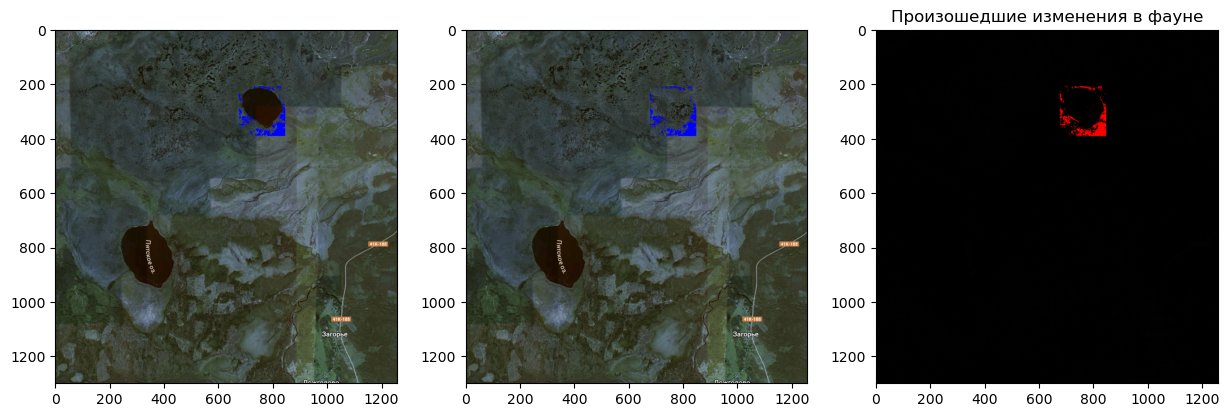

In [39]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(15, 10))

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(image1)
axarr[1].imshow(image2)
axarr[2].imshow(difference)
plt.title('Произошедшие изменения в фауне')
plt.show();

<Figure size 640x480 with 0 Axes>

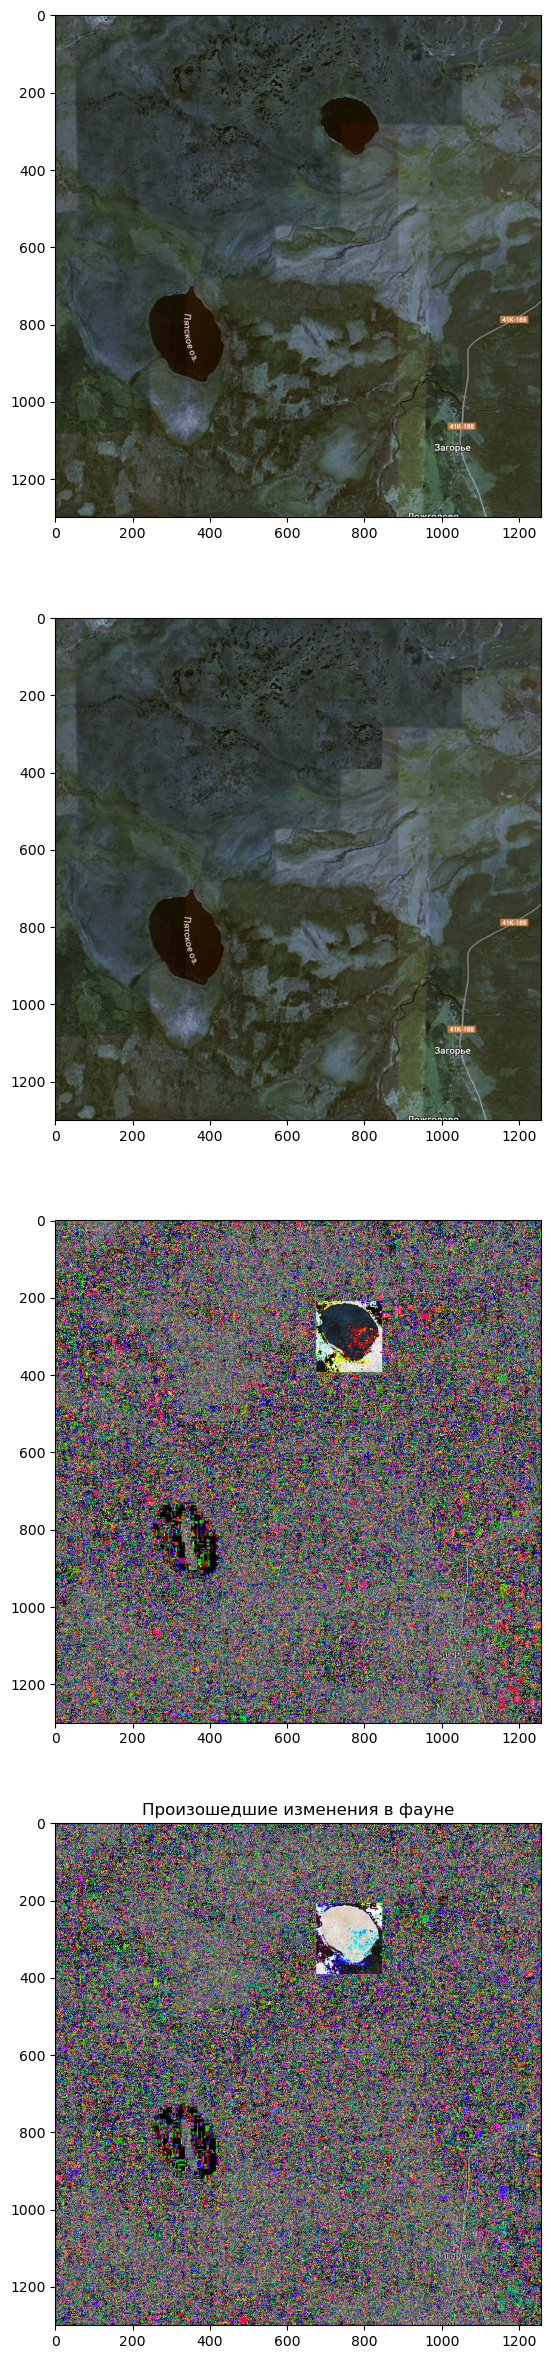

In [44]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1, figsize=(30, 30)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img1)
axarr[1].imshow(img2)
axarr[2].imshow(img2 - img1)
axarr[3].imshow(img1 - img2)
plt.title('Произошедшие изменения в фауне')
plt.show();